# คำนวณค่าสถิติความสัมพันธ์ฝนสสน.กับฝนเรดาร์รายวันทุกเหตุการณ์ในแต่ละcappi พลอตกราฟ
* อ่านและคลีนข้อมูล กรองข้อมูล dBZ10-55
* คำนวณค่า ZRs ของแต่ะล cappi
* คำนวณ matrics สถิติระหว่างความสัมพันธ์ของฝนสองแหล่ง
* พลอตกราฟ
* หมายเหตุ: ฝนรายชั่วโมง ได้มาจากการหาค่า max dBZ รายชั่วโมง ณ กริดนั้น ๆ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import linregress
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## read cleansing

In [2]:
df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events/df_org_dbz_rain_test120km.csv')
#df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events/df_org_dbz_rain_test200km.csv')
df.drop(df[df['cappi4km'] < 10].index, inplace = True) #ฝนอ่่อนมากๆ < 10 dBZ
df.drop(df[df['cappi4km'] > 55].index, inplace = True) #ค่าการสะท้อนที่อาจเป็นลูกเห็บ 55 dBZ มุมยกด้านบนสุด
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,cappi1km,cappi2km,cappi3km,cappi4km,full_date,code,rain_x
0,28.491104,28.182693,27.482676,26.134428,2018-06-01-00:00,CMSG,0.0
1,18.245508,17.964867,17.979790,18.295288,2018-06-01-00:00,CTKN,10.8
2,27.273252,27.500923,27.998676,28.672308,2018-06-01-00:00,KGTP,0.0
3,27.172401,27.172401,27.172401,27.172401,2018-06-01-00:00,LPLE,0.0
4,29.211285,29.136589,24.834078,22.473293,2018-06-01-00:00,NAN008,0.0
...,...,...,...,...,...,...,...
15877,47.794342,47.810116,47.825912,47.841797,2018-09-21-23:00,PPTC,0.0
15878,21.874329,21.874329,21.874329,21.874329,2018-09-21-23:00,TBR013,0.0
15879,28.704351,28.712242,28.719904,29.000463,2018-09-21-23:00,TBW014,0.0
15880,10.786102,10.775164,10.764159,10.816386,2018-09-21-23:00,WTBT,0.0


### เปลี่ยนชื่อคอลัมน์

In [3]:
df.rename(columns={"cappi1km": "dBZ_c1", "cappi2km": "dBZ_c2","cappi3km": "dBZ_c3","cappi4km": "dBZ_c4"}, inplace=True)
df.rename(columns={"rain_x":"rain_truth"}, inplace=True)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth
0,28.491104,28.182693,27.482676,26.134428,2018-06-01-00:00,CMSG,0.0
1,18.245508,17.964867,17.979790,18.295288,2018-06-01-00:00,CTKN,10.8
2,27.273252,27.500923,27.998676,28.672308,2018-06-01-00:00,KGTP,0.0
3,27.172401,27.172401,27.172401,27.172401,2018-06-01-00:00,LPLE,0.0
4,29.211285,29.136589,24.834078,22.473293,2018-06-01-00:00,NAN008,0.0
...,...,...,...,...,...,...,...
15877,47.794342,47.810116,47.825912,47.841797,2018-09-21-23:00,PPTC,0.0
15878,21.874329,21.874329,21.874329,21.874329,2018-09-21-23:00,TBR013,0.0
15879,28.704351,28.712242,28.719904,29.000463,2018-09-21-23:00,TBW014,0.0
15880,10.786102,10.775164,10.764159,10.816386,2018-09-21-23:00,WTBT,0.0


## แปลง dBZ เป็น rain rate ด้วย ZRs

In [4]:
def dBZ_to_rainrate_by_zr(dBZ, a=200, b=1.6):
    z = 10**(dBZ/10)
    r = (z/a)**(1/b)
    return r

### Marshall/Palmer ZR

In [5]:
# Specify the columns for dBZ and rain rate
dBZ_columns = ['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4']
rain_rate_columns = ['rr_MP_c1', 'rr_MP_c2', 'rr_MP_c3', 'rr_MP_c4']
a=200
b=1.6

# Apply the dBZ_to_rainrate_by_zr function to the specified columns
for dBZ_col, rain_rate_col in zip(dBZ_columns, rain_rate_columns):
    df[rain_rate_col] = dBZ_to_rainrate_by_zr(df[dBZ_col],a,b)

df.head()

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4
0,28.491104,28.182693,27.482676,26.134428,2018-06-01-00:00,CMSG,0.0,2.200646,2.105109,1.903371,1.567682
1,18.245508,17.964867,17.979790,18.295288,2018-06-01-00:00,CTKN,10.8,0.503733,0.483794,0.484834,0.507355
2,27.273252,27.500923,27.998676,28.672308,2018-06-01-00:00,KGTP,0.0,1.846862,1.908376,2.050093,2.258788
3,27.172401,27.172401,27.172401,27.172401,2018-06-01-00:00,LPLE,0.0,1.820251,1.820251,1.820251,1.820251
4,29.211285,29.136589,24.834078,22.473293,2018-06-01-00:00,NAN008,0.0,2.440965,2.414866,1.300128,0.925629


### Rosenfeld Zr

In [6]:
# Specify the columns for dBZ and rain rate
dBZ_columns = ['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4']
rain_rate_columns = ['rr_RF_c1', 'rr_RF_c2', 'rr_RF_c3', 'rr_RF_c4']
a=250. 
b=1.2

# Apply the dBZ_to_rainrate_by_zr function to the specified columns
for dBZ_col, rain_rate_col in zip(dBZ_columns, rain_rate_columns):
    df[rain_rate_col] = dBZ_to_rainrate_by_zr(df[dBZ_col],a,b)

df.head()

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4
0,28.491104,28.182693,27.482676,26.134428,2018-06-01-00:00,CMSG,0.0,2.200646,2.105109,1.903371,1.567682,2.376705,2.240136,1.958572,1.512118
1,18.245508,17.964867,17.979790,18.295288,2018-06-01-00:00,CTKN,10.8,0.503733,0.483794,0.484834,0.507355,0.332794,0.315347,0.316251,0.335988
2,27.273252,27.500923,27.998676,28.672308,2018-06-01-00:00,KGTP,0.0,1.846862,1.908376,2.050093,2.258788,1.881428,1.965442,2.162418,2.460796
3,27.172401,27.172401,27.172401,27.172401,2018-06-01-00:00,LPLE,0.0,1.820251,1.820251,1.820251,1.820251,1.845370,1.845370,1.845370,1.845370
4,29.211285,29.136589,24.834078,22.473293,2018-06-01-00:00,NAN008,0.0,2.440965,2.414866,1.300128,0.925629,2.728917,2.690083,1.178211,0.749016


### Summer Deep Convective ZR

In [7]:
# Specify the columns for dBZ and rain rate
dBZ_columns = ['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4']
rain_rate_columns = ['rr_SC_c1', 'rr_SC_c2', 'rr_SC_c3', 'rr_SC_c4']

a=300. 
b=1.4

# Apply the dBZ_to_rainrate_by_zr function to the specified columns
for dBZ_col, rain_rate_col in zip(dBZ_columns, rain_rate_columns):
    df[rain_rate_col] = dBZ_to_rainrate_by_zr(df[dBZ_col],a,b)

df.head()

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,28.491104,28.182693,27.482676,26.134428,2018-06-01-00:00,CMSG,0.0,2.200646,2.105109,1.903371,1.567682,2.376705,2.240136,1.958572,1.512118,1.843769,1.752577,1.561982,1.251332
1,18.245508,17.964867,17.979790,18.295288,2018-06-01-00:00,CTKN,10.8,0.503733,0.483794,0.484834,0.507355,0.332794,0.315347,0.316251,0.335988,0.341884,0.326462,0.327264,0.344694
2,27.273252,27.500923,27.998676,28.672308,2018-06-01-00:00,KGTP,0.0,1.846862,1.908376,2.050093,2.258788,1.881428,1.965442,2.162418,2.460796,1.509097,1.566677,1.700330,1.899545
3,27.172401,27.172401,27.172401,27.172401,2018-06-01-00:00,LPLE,0.0,1.820251,1.820251,1.820251,1.820251,1.845370,1.845370,1.845370,1.845370,1.484272,1.484272,1.484272,1.484272
4,29.211285,29.136589,24.834078,22.473293,2018-06-01-00:00,NAN008,0.0,2.440965,2.414866,1.300128,0.925629,2.728917,2.690083,1.178211,0.749016,2.075621,2.050277,1.010393,0.685272


#### ดรอปคอมลัมน์ cappi ทิ้ง

In [8]:
#### ดรอปคอมลัมน์ cappi ทิ้ง
df.drop(columns=['dBZ_c1','dBZ_c2','dBZ_c3','dBZ_c4'], inplace=True) #ลบคอลัน์
df

,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,2018-06-01-00:00,CMSG,0.0,2.200646,2.105109,1.903371,1.567682,2.376705,2.240136,1.958572,1.512118,1.843769,1.752577,1.561982,1.251332
1,2018-06-01-00:00,CTKN,10.8,0.503733,0.483794,0.484834,0.507355,0.332794,0.315347,0.316251,0.335988,0.341884,0.326462,0.327264,0.344694
2,2018-06-01-00:00,KGTP,0.0,1.846862,1.908376,2.050093,2.258788,1.881428,1.965442,2.162418,2.460796,1.509097,1.566677,1.700330,1.899545
3,2018-06-01-00:00,LPLE,0.0,1.820251,1.820251,1.820251,1.820251,1.845370,1.845370,1.845370,1.845370,1.484272,1.484272,1.484272,1.484272
4,2018-06-01-00:00,NAN008,0.0,2.440965,2.414866,1.300128,0.925629,2.728917,2.690083,1.178211,0.749016,2.075621,2.050277,1.010393,0.685272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15877,2018-09-21-23:00,PPTC,0.0,35.399949,35.480399,35.561149,35.642533,96.511373,96.803927,97.097795,97.394194,44.107176,44.221752,44.336793,44.452775
15878,2018-09-21-23:00,TBR013,0.0,0.849184,0.849184,0.849184,0.849184,0.667694,0.667694,0.667694,0.667694,0.620983,0.620983,0.620983,0.620983
15879,2018-09-21-23:00,TBW014,0.0,2.269228,2.271807,2.274313,2.368019,2.475973,2.479725,2.483373,2.620728,1.909583,1.912063,1.914474,2.004884
15880,2018-09-21-23:00,WTBT,0.0,0.172182,0.171911,0.171639,0.172934,0.079535,0.079368,0.079201,0.079999,0.100245,0.100065,0.099884,0.100746


#### รวมฝนรายชั่วโมงเป็นรายวัน ด้วยการสร้างคอลัมน์ date_only เพื่อใช้ร่วมกับคอลัมน์ code

In [9]:
# Extract date from 'full_date' column
df['date_only'] = pd.to_datetime(df['full_date']).dt.date

# Group by 'date_only' and 'code', then sum the 'rain_truth' values
aggregated_data = df.groupby(['date_only', 'code']).sum().reset_index()

# replace NaN with 0 after aggregation using fillna(0)
#aggregated_data.fillna(0, inplace=True)

aggregated_data.dropna(inplace=True)
aggregated_data.reset_index(drop=True)

aggregated_data.head()

,date_only,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,2018-06-01,BPPS,0.2,2.224783,2.364574,2.692157,2.978155,1.993129,2.163233,2.586858,2.971593,1.716766,1.841046,2.140117,2.405615
1,2018-06-01,BRKM,0.0,1.505886,1.525648,1.444603,1.434436,0.760334,0.781019,0.720767,0.711913,0.910027,0.926918,0.868426,0.860466
2,2018-06-01,BWKG,0.0,3.995276,4.059923,4.273930,3.657418,2.540471,2.601583,2.810899,2.286203,2.657116,2.708626,2.881853,2.411153
3,2018-06-01,CMSG,4.8,23.705733,23.180283,22.594044,20.573030,32.660637,31.823973,30.868768,27.195866,21.954865,21.431417,20.840512,18.709725
4,2018-06-01,CNDN,0.0,19.720062,19.699903,17.066963,4.122306,44.237035,44.176752,36.485195,5.488183,22.600377,22.573976,19.160159,3.777791


#### conditional rain
เป็นหนึ่งในกระบวนการ QC การจับคู่ของฝนเรดาร์กับฝนสถานี อ่านรายละเอียด
http://www.iapjournals.ac.cn/fileDQKXJZ/journal/article/dqkxjz/2012/3/PDF/110139.pdf

In [10]:
# conditional rain
df_=aggregated_data[aggregated_data['rain_truth']>0]
df_=df_[df_['rr_SC_c1']>0]
df_.reset_index(drop=True, inplace=True)
df_.describe()

,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
count,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000
mean,6.041728,24.893924,24.462577,23.834845,22.629126,48.393811,46.675708,44.434669,41.011305,26.133798,25.483899,24.590591,23.080241
std,9.312912,26.671079,25.373615,24.200754,22.947070,76.904748,72.212201,68.884078,62.882869,33.562202,31.740719,30.195358,28.204408
min,0.200000,0.254467,0.254467,0.248829,0.204654,0.133891,0.133891,0.129950,0.100139,0.156654,0.156654,0.152694,0.122128
25%,0.600000,7.911515,8.176571,8.104146,7.609847,7.681209,8.149178,7.997979,7.716233,6.248620,6.558034,6.575365,6.183616
50%,2.000000,15.830127,16.213940,16.376425,15.270341,18.631287,19.668242,19.665261,17.944076,13.417577,14.114142,14.317393,13.270842
75%,7.400000,32.379022,32.037420,31.249555,29.758160,54.725120,54.296406,52.876648,47.624060,32.055762,32.129860,31.817498,29.020798
max,77.800000,228.183390,227.045673,228.916910,230.459121,792.501507,676.013101,680.585234,735.220899,309.774029,290.594113,292.815522,304.763985


In [11]:
df_.corr()

,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
rain_truth,1.000000,0.540352,0.554213,0.552960,0.548257,0.484251,0.491446,0.478224,0.479239,0.519209,0.530567,0.525361,0.522586
rr_MP_c1,0.540352,1.000000,0.961138,0.928622,0.871465,0.970175,0.925207,0.882102,0.832693,0.993018,0.951610,0.916091,0.861313
rr_MP_c2,0.554213,0.961138,1.000000,0.970916,0.914097,0.918033,0.969135,0.925413,0.877817,0.947954,0.992709,0.959148,0.905244
rr_MP_c3,0.552960,0.928622,0.970916,1.000000,0.937978,0.883943,0.933529,0.963230,0.899878,0.913753,0.959986,0.991516,0.928221
rr_MP_c4,0.548257,0.871465,0.914097,0.937978,1.000000,0.807835,0.854297,0.866128,0.965400,0.847250,0.892386,0.913594,0.991743
rr_RF_c1,0.484251,0.970175,0.918033,0.883943,0.807835,1.000000,0.938460,0.895817,0.818039,0.991728,0.935552,0.899432,0.821482
rr_RF_c2,0.491446,0.925207,0.969135,0.933529,0.854297,0.938460,1.000000,0.950173,0.872022,0.939341,0.991514,0.951770,0.871700
rr_RF_c3,0.478224,0.882102,0.925413,0.963230,0.866128,0.895817,0.950173,1.000000,0.887354,0.895464,0.944417,0.989639,0.885019
rr_RF_c4,0.479239,0.832693,0.877817,0.899878,0.965400,0.818039,0.872022,0.887354,1.000000,0.833041,0.882983,0.904923,0.990644
rr_SC_c1,0.519209,0.993018,0.947954,0.913753,0.847250,0.991728,0.939341,0.895464,0.833041,1.000000,0.951842,0.915093,0.849274


## EDA

### Correlation matrix

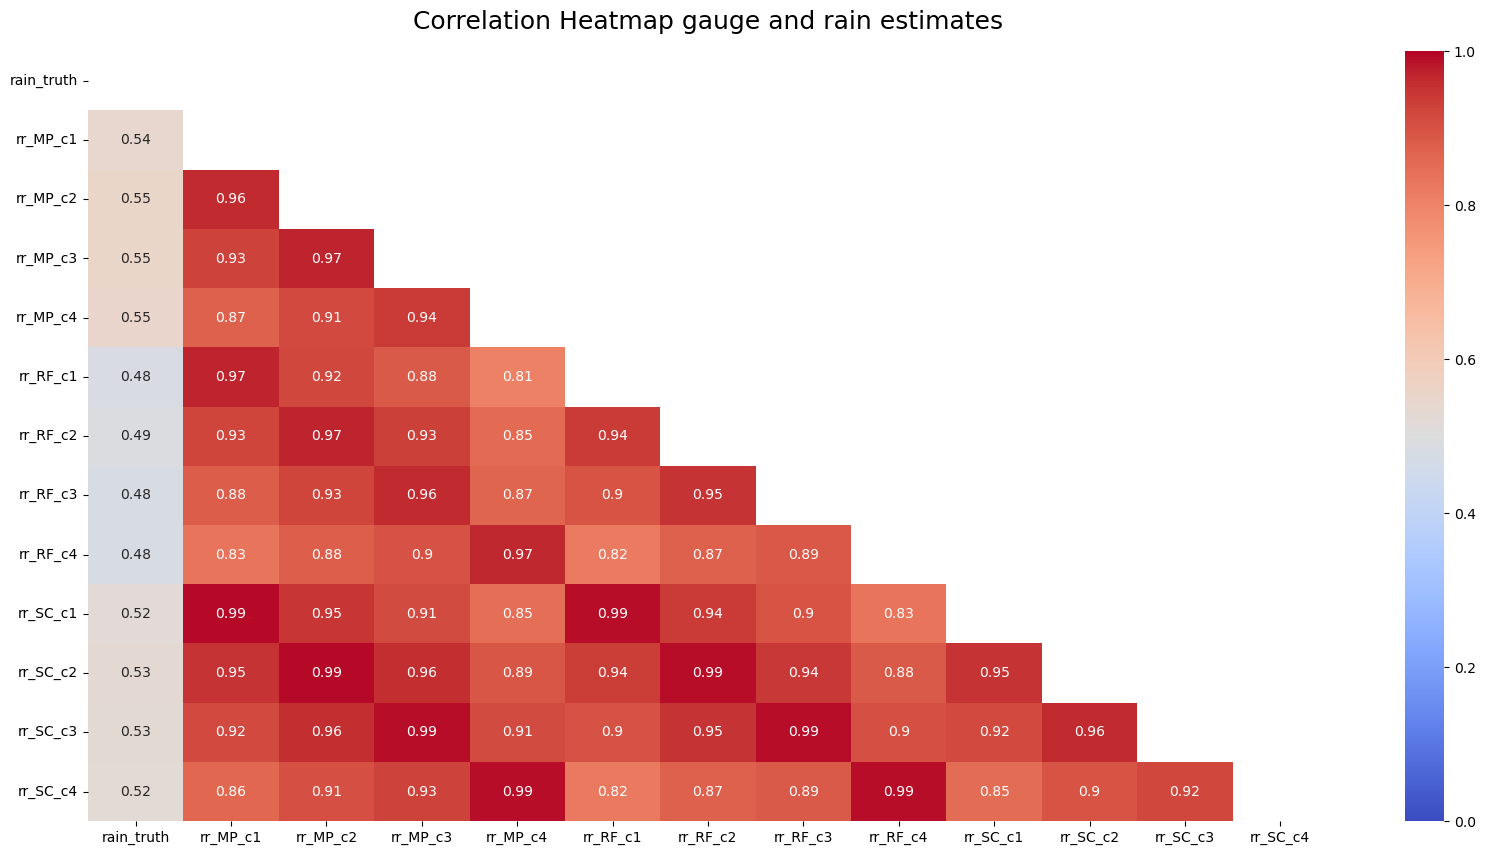

In [12]:
plt.figure(figsize=(20, 10))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_.corr(), dtype=bool))
heatmap = sns.heatmap(df_.corr(), mask=mask, vmin=0, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap gauge and rain estimates', fontdict={'fontsize':18}, pad=16);

### Scatter plot & สถิติจากฝนสองแหล่ง

In [13]:
def density_plot(rain_truth, rain_radar,cappi_height):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    from scipy.stats import linregress
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # data
    x = rain_radar
    y = rain_truth

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create scatter plot with density color map
    fig, ax = plt.subplots()
    scatter = ax.scatter(x, y, c=z, s=20, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)

    
    max_ = 50
    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_truth [mm/hr]')
    plt.ylabel('rain_radar [mm/hr]')

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Calculate metrics
    bias = rain_radar.mean()/rain_truth.mean()
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Plot the regression line
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    plt.xlabel('rain_radar [mm/day]')
    plt.ylabel('rain_truth [mm/day]')
    plt.title('Daily rain '+ cappi_height + '[mm/day]')
    plt.legend()

    # Display the plot
    plt.show()
    
    return bias,rmse,mse,mae,r2,r_value
    


RMSE: 29.7425491597901
MSE: 884.6192305225309
MAE: 19.459217121427617
R-squared: -0.24459852895950673
Correlation coefficient (r): 0.5403522249181237
P-value: 5.983273678013612e-94


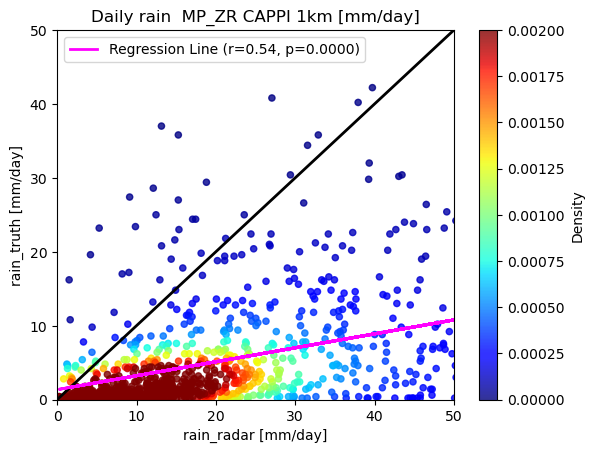

RMSE: 28.417829835286987
MSE: 807.5730525473273
MAE: 18.89351725697328
R-squared: -0.2553685186307597
Correlation coefficient (r): 0.5542126186083381
P-value: 1.0097427302561151e-99


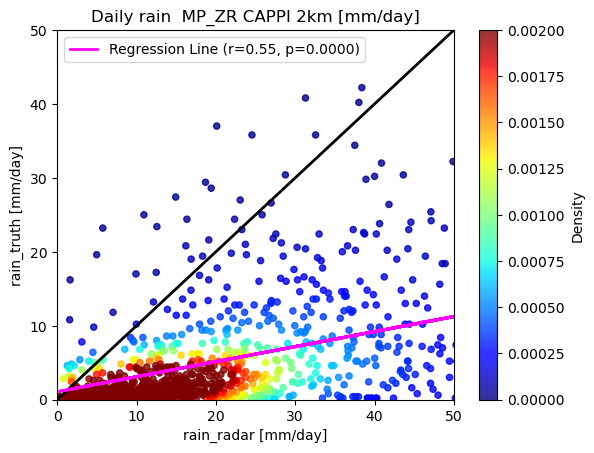

RMSE: 27.19201125082334
MSE: 739.4054758649032
MAE: 18.196440807745823
R-squared: -0.26351077622868546
Correlation coefficient (r): 0.552959607411898
P-value: 3.445735945471753e-99


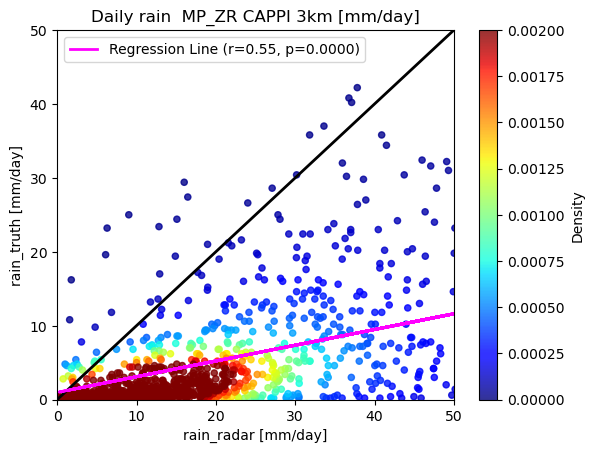

RMSE: 25.569546195781275
MSE: 653.8016926581927
MAE: 17.060411696901284
R-squared: -0.24264087846067595
Correlation coefficient (r): 0.5482572853836608
P-value: 3.2940608726424564e-97


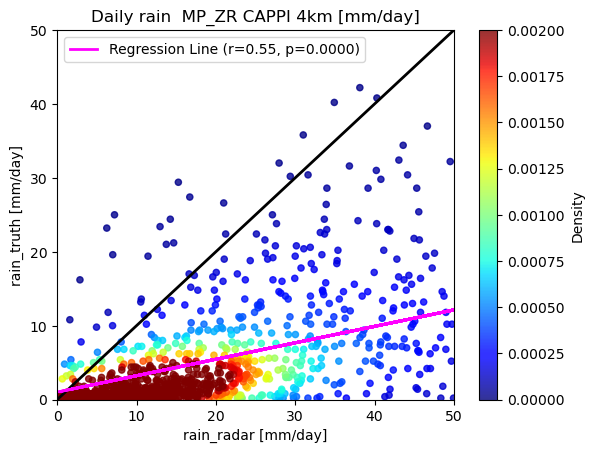

,0,1,2,3,4,5
0,4.120332,29.742549,884.619231,19.459217,-0.244599,0.540352
1,4.048937,28.417830,807.573053,18.893517,-0.255369,0.554213
2,3.945038,27.192011,739.405476,18.196441,-0.263511,0.552960
3,3.745473,25.569546,653.801693,17.060412,-0.242641,0.548257


In [14]:
stat_mp=[]
bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_MP_c1'],' MP_ZR CAPPI 1km ')
stat_mp.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_MP_c2'],' MP_ZR CAPPI 2km ')
stat_mp.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_MP_c3'],' MP_ZR CAPPI 3km ')
stat_mp.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_MP_c4'],' MP_ZR CAPPI 4km ')
stat_mp.append((bias,rmse,mse,mae,r2,r_value))

stat_mp_df=pd.DataFrame(stat_mp)
stat_mp_df

In [15]:
stat_mp_df

,0,1,2,3,4,5
0,4.120332,29.742549,884.619231,19.459217,-0.244599,0.540352
1,4.048937,28.417830,807.573053,18.893517,-0.255369,0.554213
2,3.945038,27.192011,739.405476,18.196441,-0.263511,0.552960
3,3.745473,25.569546,653.801693,17.060412,-0.242641,0.548257


RMSE: 84.24248397263818
MSE: 7096.796105880201
MAE: 42.754366978770705
R-squared: -0.20090903671689397
Correlation coefficient (r): 0.48425090630389367
P-value: 3.875835117232847e-73


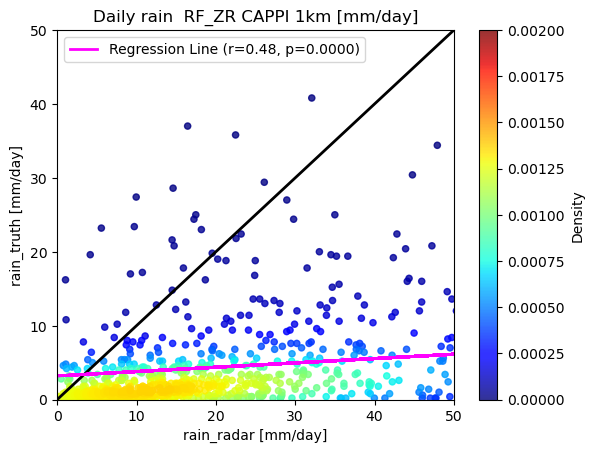

RMSE: 79.2948296083339
MSE: 6287.670002614706
MAE: 40.87855068021421
R-squared: -0.20676489211146287
Correlation coefficient (r): 0.4914461291771271
P-value: 1.3527918172202774e-75


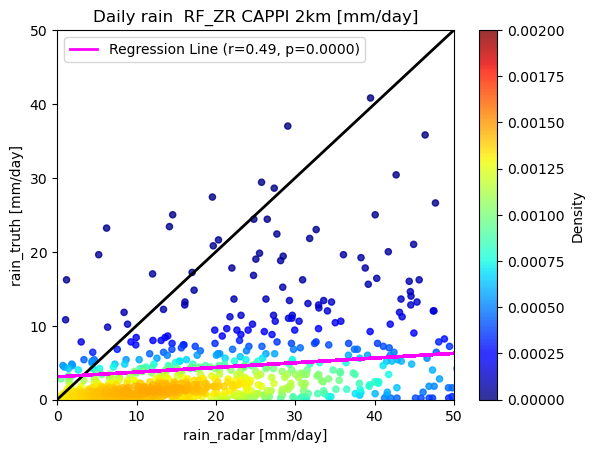

RMSE: 75.42383592518433
MSE: 5688.7550256691275
MAE: 38.61208368915577
R-squared: -0.19986842117192305
Correlation coefficient (r): 0.47822355003060474
P-value: 3.999709605739674e-71


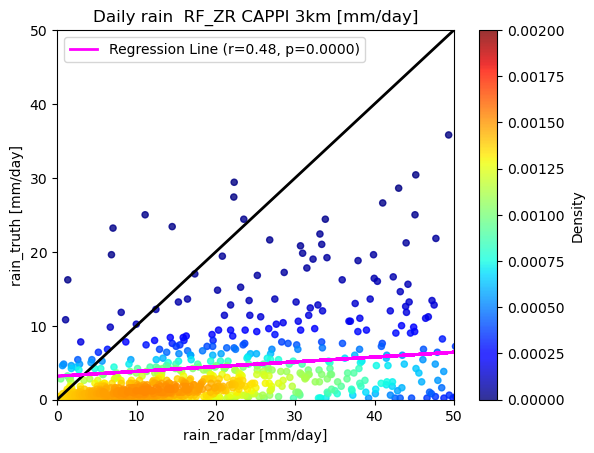

RMSE: 68.55446358199973
MSE: 4699.714477015727
MAE: 35.214147648325934
R-squared: -0.18949018743414503
Correlation coefficient (r): 0.4792390854799929
P-value: 1.8431646422798225e-71


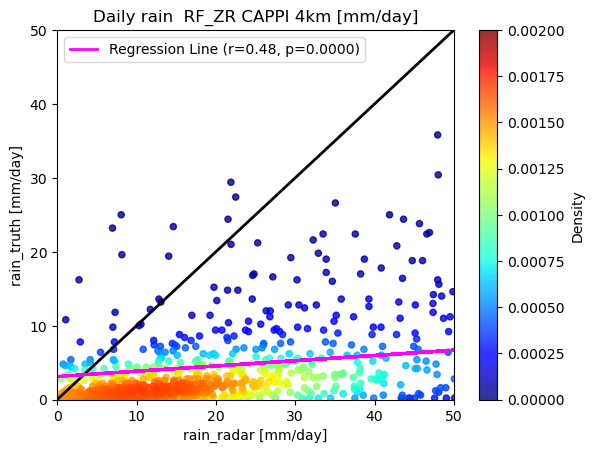

,0,1,2,3,4,5
0,8.009929,84.242484,7096.796106,42.754367,-0.200909,0.484251
1,7.725556,79.294830,6287.670003,40.878551,-0.206765,0.491446
2,7.354629,75.423836,5688.755026,38.612084,-0.199868,0.478224
3,6.788009,68.554464,4699.714477,35.214148,-0.189490,0.479239


In [16]:
stat_rf=[]
bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_RF_c1'],' RF_ZR CAPPI 1km ')
stat_rf.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_RF_c2'],' RF_ZR CAPPI 2km ')
stat_rf.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_RF_c3'],' RF_ZR CAPPI 3km ')
stat_rf.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_RF_c4'],' RF_ZR CAPPI 4km ')
stat_rf.append((bias,rmse,mse,mae,r2,r_value))

stat_rf_df=pd.DataFrame(stat_rf)
stat_rf_df

RMSE: 35.93812839943474
MSE: 1291.549072854258
MAE: 20.805494375688916
R-squared: -0.14753015643871437
Correlation coefficient (r): 0.519208864048863
P-value: 1.20371723829763e-85


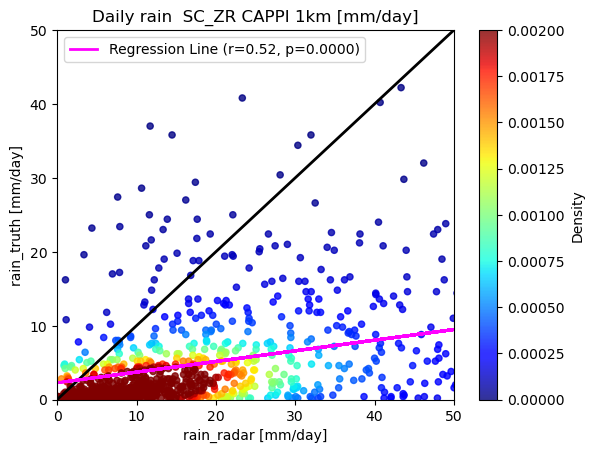

RMSE: 34.02787250077668
MSE: 1157.896106929114
MAE: 19.981554639088596
R-squared: -0.15024447104502525
Correlation coefficient (r): 0.5305665741935915
P-value: 4.934163052643942e-90


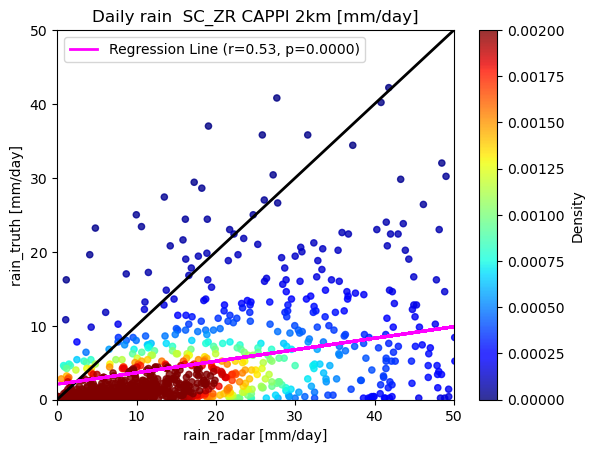

RMSE: 32.34976071593745
MSE: 1046.5070183784098
MAE: 18.98957361507561
R-squared: -0.1487244825298153
Correlation coefficient (r): 0.5253614173739565
P-value: 5.303669220664173e-88


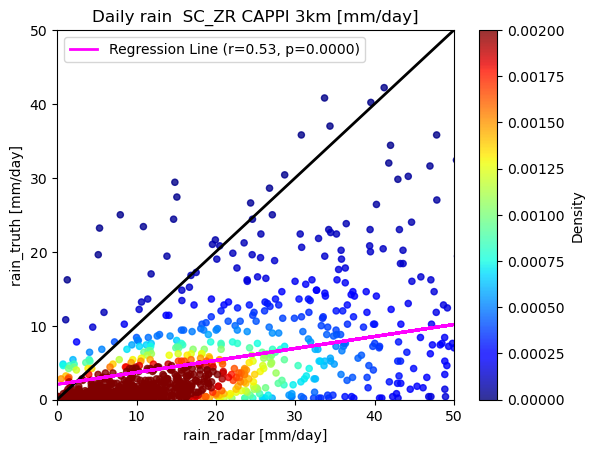

RMSE: 29.95837656379298
MSE: 897.5043263380205
MAE: 17.530054226411544
R-squared: -0.1291630623734179
Correlation coefficient (r): 0.5225860830932885
P-value: 6.213102706420212e-87


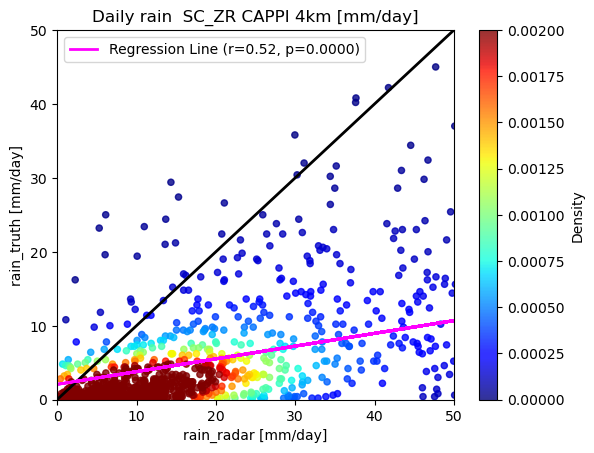

,0,1,2,3,4,5
0,4.325550,35.938128,1291.549073,20.805494,-0.147530,0.519209
1,4.217982,34.027873,1157.896107,19.981555,-0.150244,0.530567
2,4.070126,32.349761,1046.507018,18.989574,-0.148724,0.525361
3,3.820139,29.958377,897.504326,17.530054,-0.129163,0.522586


In [17]:
stat_sc=[]
bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_SC_c1'],' SC_ZR CAPPI 1km ')
stat_sc.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_SC_c2'],' SC_ZR CAPPI 2km ')
stat_sc.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_SC_c3'],' SC_ZR CAPPI 3km ')
stat_sc.append((bias,rmse,mse,mae,r2,r_value))

bias,rmse,mse,mae,r2,r_value=density_plot(df_['rain_truth'],df_['rr_SC_c4'],' SC_ZR CAPPI 4km ')
stat_sc.append((bias,rmse,mse,mae,r2,r_value))

stat_sc_df=pd.DataFrame(stat_sc)
stat_sc_df

In [18]:
stat_sc_df

,0,1,2,3,4,5
0,4.325550,35.938128,1291.549073,20.805494,-0.147530,0.519209
1,4.217982,34.027873,1157.896107,19.981555,-0.150244,0.530567
2,4.070126,32.349761,1046.507018,18.989574,-0.148724,0.525361
3,3.820139,29.958377,897.504326,17.530054,-0.129163,0.522586


#### สถิติฝนสองแหล่ง

In [19]:
### สถิติฝนสองแหล่ง
# bias,rmse,mse,mae,r2,r_value
print(stat_mp_df)
print(stat_rf_df)
print(stat_sc_df)

          0          1           2          3         4         5
0  4.120332  29.742549  884.619231  19.459217 -0.244599  0.540352
1  4.048937  28.417830  807.573053  18.893517 -0.255369  0.554213
2  3.945038  27.192011  739.405476  18.196441 -0.263511  0.552960
3  3.745473  25.569546  653.801693  17.060412 -0.242641  0.548257
          0          1            2          3         4         5
0  8.009929  84.242484  7096.796106  42.754367 -0.200909  0.484251
1  7.725556  79.294830  6287.670003  40.878551 -0.206765  0.491446
2  7.354629  75.423836  5688.755026  38.612084 -0.199868  0.478224
3  6.788009  68.554464  4699.714477  35.214148 -0.189490  0.479239
          0          1            2          3         4         5
0  4.325550  35.938128  1291.549073  20.805494 -0.147530  0.519209
1  4.217982  34.027873  1157.896107  19.981555 -0.150244  0.530567
2  4.070126  32.349761  1046.507018  18.989574 -0.148724  0.525361
3  3.820139  29.958377   897.504326  17.530054 -0.129163  0.522586


In [20]:
stat_mp_df['cappi']=[1,2,3,4]
stat_rf_df['cappi']=[1,2,3,4]
stat_sc_df['cappi']=[1,2,3,4]

In [21]:
stat_mp_df['ZR relationship']='MS/PM'
stat_rf_df['ZR relationship']='RF'
stat_sc_df['ZR relationship']='SC'
print(stat_mp_df)
print(stat_rf_df)
print(stat_sc_df)

          0          1           2          3         4         5  cappi  \
0  4.120332  29.742549  884.619231  19.459217 -0.244599  0.540352      1   
1  4.048937  28.417830  807.573053  18.893517 -0.255369  0.554213      2   
2  3.945038  27.192011  739.405476  18.196441 -0.263511  0.552960      3   
3  3.745473  25.569546  653.801693  17.060412 -0.242641  0.548257      4   

  ZR relationship  
0           MS/PM  
1           MS/PM  
2           MS/PM  
3           MS/PM  
          0          1            2          3         4         5  cappi  \
0  8.009929  84.242484  7096.796106  42.754367 -0.200909  0.484251      1   
1  7.725556  79.294830  6287.670003  40.878551 -0.206765  0.491446      2   
2  7.354629  75.423836  5688.755026  38.612084 -0.199868  0.478224      3   
3  6.788009  68.554464  4699.714477  35.214148 -0.189490  0.479239      4   

  ZR relationship  
0              RF  
1              RF  
2              RF  
3              RF  
          0          1           

In [22]:
#### รวม dataframe by concat
frames = [stat_mp_df,stat_rf_df,stat_sc_df]
df_zr= pd.concat(frames)
#print(df_zr)

#### rename columns # bias,rmse,mse,mae,r2,r_value
df_zr.rename(columns={0: "bias", 1: "rmse",2:"mse",3:"mae", 4:"r2", 5:"r"}, inplace=True)


In [23]:
df_zr.columns

Index(['bias', 'rmse', 'mse', 'mae', 'r2', 'r', 'cappi', 'ZR relationship'], dtype='object')

In [24]:
df_zr

,bias,rmse,mse,mae,r2,r,cappi,ZR relationship
0,4.120332,29.742549,884.619231,19.459217,-0.244599,0.540352,1,MS/PM
1,4.048937,28.417830,807.573053,18.893517,-0.255369,0.554213,2,MS/PM
2,3.945038,27.192011,739.405476,18.196441,-0.263511,0.552960,3,MS/PM
3,3.745473,25.569546,653.801693,17.060412,-0.242641,0.548257,4,MS/PM
0,8.009929,84.242484,7096.796106,42.754367,-0.200909,0.484251,1,RF
1,7.725556,79.294830,6287.670003,40.878551,-0.206765,0.491446,2,RF
2,7.354629,75.423836,5688.755026,38.612084,-0.199868,0.478224,3,RF
3,6.788009,68.554464,4699.714477,35.214148,-0.189490,0.479239,4,RF
0,4.325550,35.938128,1291.549073,20.805494,-0.147530,0.519209,1,SC
1,4.217982,34.027873,1157.896107,19.981555,-0.150244,0.530567,2,SC


## พลอตกราฟ สถิติ
bias,rmse,mse,mae,r2,r_value

#### Mean Field Bias

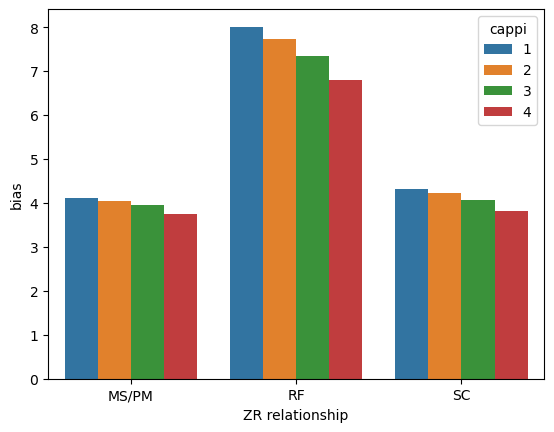

In [25]:
sns.barplot(x = 'ZR relationship', y = 'bias', hue = "cappi", order = ["MS/PM", "RF", "SC"], data = df_zr)
plt.show()

#### r_value

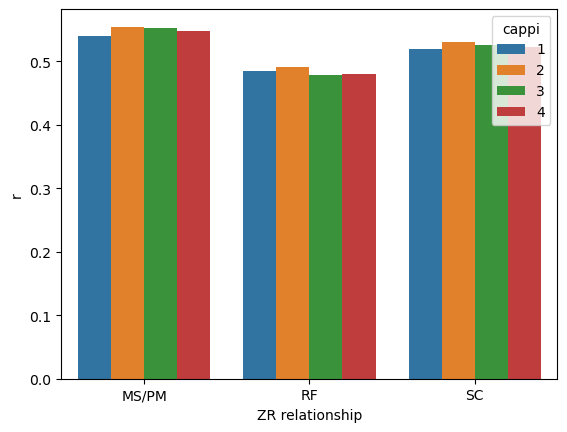

In [26]:
sns.barplot(x = 'ZR relationship', y = 'r', hue = "cappi", order = ["MS/PM", "RF", "SC"], data = df_zr)
plt.show()

#### rmse

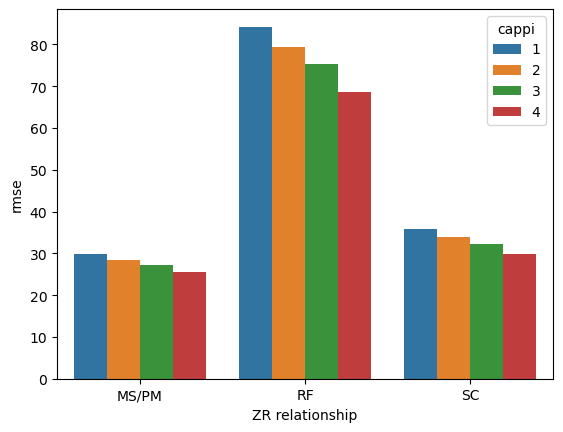

In [27]:
sns.barplot(x = 'ZR relationship', y = 'rmse', hue = "cappi", order = ["MS/PM", "RF", "SC"], data = df_zr)
plt.show()

#### mae

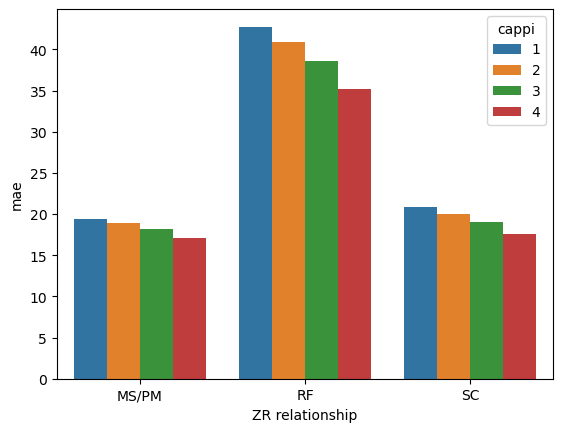

In [28]:
sns.barplot(x = 'ZR relationship', y = 'mae', hue = "cappi", order = ["MS/PM", "RF", "SC"], data = df_zr)
plt.show()

#### r2

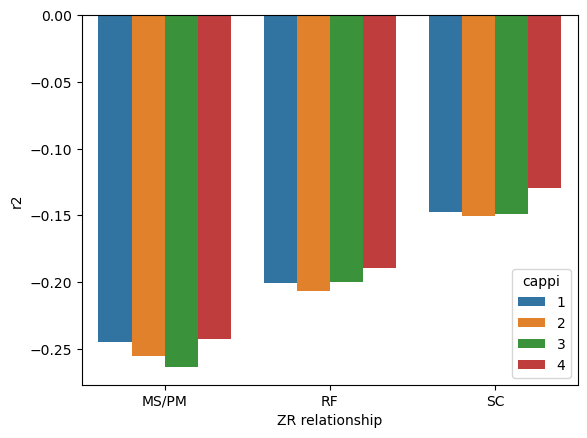

In [29]:
sns.barplot(x = 'ZR relationship', y = 'r2', hue = "cappi", order = ["MS/PM", "RF", "SC"], data = df_zr)
plt.show()

## ข้อสังเกต
* bias MS/PM ค่อนข้างต่ำ ค่า corr ก็ค่อนข้างดีกว่า zr ตัวอื่น 
* ควรทดสอบการปรับแก้ MFB 

## ทดสอบปรับแก้ MFB

In [30]:
df_=aggregated_data
MFB=df_['rr_MP_c1'].mean()/df_['rain_truth'].mean()

# ทดสอบปรับแก้ MFB ด้วยการคูณเข้ากับฝนประมาณค่าจากเรดาร์
df_['corrected_rr_MP_c1']=df_['rr_MP_c1']*(1/MFB)    

#ต้องนำ MFB ไปปรับแก้ค่าฝน validate / testing

In [31]:
def density_plot_joint_events(rain_truth,rain_radar):
    # data
    x = rain_radar
    y = rain_truth

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create a joint plot with scatter plot, regression line, and density plot
    sns.set(style="whitegrid")
    g = sns.jointplot(x=x, y=y, kind="reg", height=7)
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    #plt.text(0.5, 0.9, f'r = {r_value:.2f}, p = {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=g.ax_joint.transAxes)

    # Add scatter plot with density color map
    scatter = plt.scatter(x, y, c=z, s=10, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)
    
    # Set scatter plot aspect ratio to be equal
    #plt.gca().set_aspect('equal', adjustable='box')

    # Set x and y axis limits
    max_=50
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_radar [mm]')
    plt.ylabel('rain_truth [mm]')
    plt.title('Events rain_radar and rain_truth [mm]')

    # Add colorbar using the scatter variable
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()

RMSE: 24.43941592183716
MSE: 597.2850506005476
MAE: 13.75564207995237
R-squared: -0.09759715111875056
Correlation coefficient (r): 0.5378120396517827
P-value: 1.2050377599212064e-190


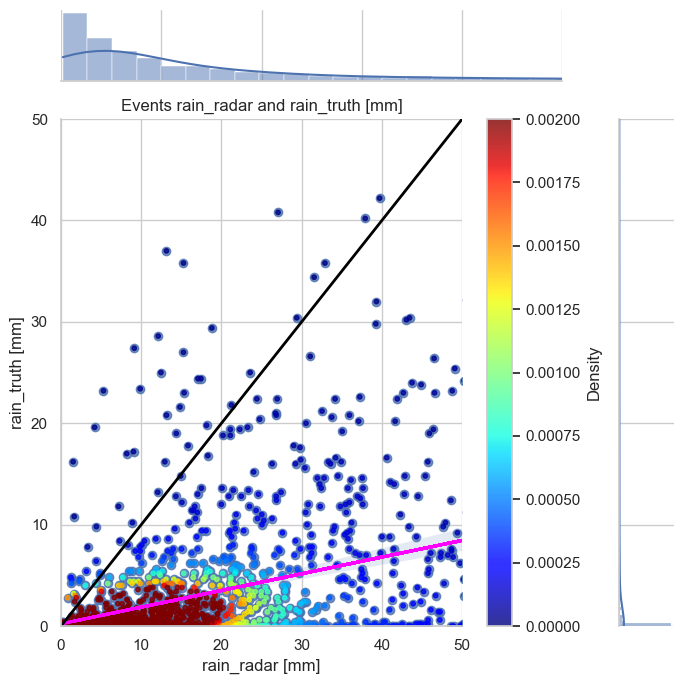

In [32]:
# ก่อนปรับแก้ MFB
density_plot_joint_events(df_['rain_truth'],df_['rr_MP_c1'])

RMSE: 6.02461736027409
MSE: 36.29601433771594
MAE: 2.8687899600316418
R-squared: -1.1053176801057525
Correlation coefficient (r): 0.5378120396517828
P-value: 1.205037759920864e-190


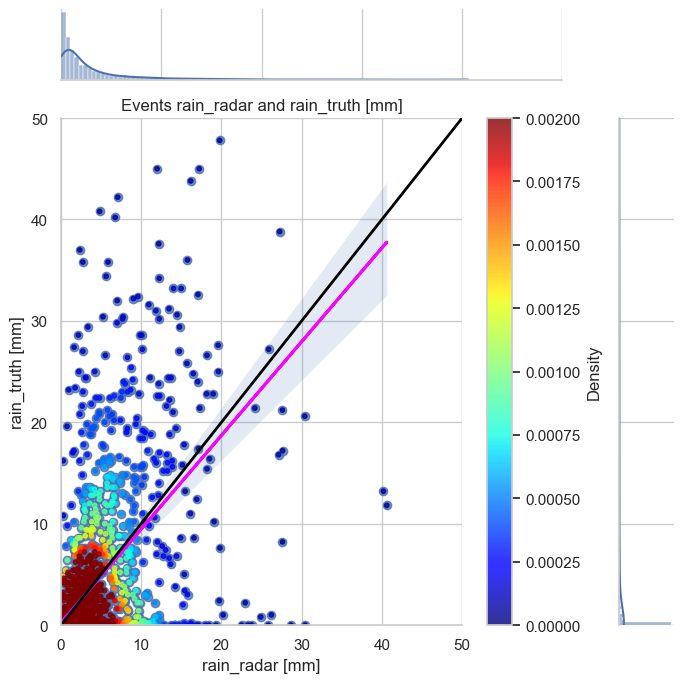

In [33]:
# หลังปรับแก้ MFB
density_plot_joint_events(df_['rain_truth'],df_['corrected_rr_MP_c1'])